# Run Qwen2.5-VL-32B-Instruct on Amazon SageMaker AI with SGLang

❗This notebook works well on `ml.g5.xlarge` instance with 100GB of disk size and `PyTorch 2.2.0 Python 3.10 CPU optimized kernel` from **SageMaker Studio Classic** or `Python3 kernel` from **JupyterLab**

Note that SageMaker provides [pre-built SageMaker AI Docker images](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) that can help you quickly start with the model inference on SageMaker. It also allows you to [bring your own Docker container](https://docs.aws.amazon.com/sagemaker/latest/dg/adapt-inference-container.html) and use it inside SageMaker AI for training and inference. To be compatible with SageMaker AI, your container must have the following characteristics:

- Your container must have a web server listening on port `8080`.
- Your container must accept POST requests to the `/invocations` and `/ping` real-time endpoints.

In this notebook, we'll demonstrate how to adapt the [SGLang](https://github.com/sgl-project/sglang) framework to run on SageMaker AI endpoints. SGLang is a serving framework for large language models that provides state-of-the-art performance, including a fast backend runtime for efficient serving with RadixAttention, extensive model support, and an active open-source community. For more information refer to [https://docs.sglang.ai/index.html](https://docs.sglang.ai/index.html) and [https://github.com/sgl-project/sglang](https://github.com/sgl-project/sglang).

By using SGLang and building a custom Docker container, you can run advanced AI models like the [Qwen2.5-VL-32B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-32B-Instruct)  model on a SageMaker AI endpoint.

### Set up Environment

In [ ]:
%%capture --no-stderr

!pip install -U pip
!pip install -U "sagemaker>=2.237.3"

### Create SageMaker AI endpoint for Qwen2.5-VL-32B model

In [ ]:
import boto3

region = boto3.Session().region_name
region

In [ ]:
import boto3
from typing import List


def get_cfn_outputs(stackname: str, region_name: str='us-east-1') -> List:
    cfn = boto3.client('cloudformation', region_name=region_name)
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

In [ ]:
CFN_STACK_NAME = "QwenVLSGLangRealtimeEndpointStack"
cfn_stack_outputs = get_cfn_outputs(CFN_STACK_NAME, region)

endpoint_name = cfn_stack_outputs['EndpointName']
model_name = cfn_stack_outputs['ModelName']

model_name, endpoint_name

In [ ]:
from sagemaker import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

### Invoke endpoint with SageMaker Python SDK

In [ ]:
%%time

# https://github.com/sgl-project/sglang/blob/v0.4.4.post3/python/sglang/srt/conversation.py#L499
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
                },
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

response = predictor.predict({
    'model': 'default',
    'messages': messages,
    'temperature': 0.6,
    'max_new_tokens': 128,
    'do_sample': True,
    'top_p': 0.95,
})

print(response['choices'][0]['message']['content'])

This image captures a heartwarming and serene moment between a woman and her dog on a sandy beach during what appears to be sunset. Here are the key details:

### **Setting:**
- **Location:** The scene takes place on a beach with soft sand, gentle waves, and a calm ocean in the background.
- **Lighting:** The lighting suggests it is either sunrise or sunset, with warm, golden sunlight casting a soft glow on the scene. The sun is low in the sky, creating a warm, peaceful ambiance.

### **Subjects:**
1. **Woman:**
   - She is sitting on the sand with her legs crossed.
   - She is wearing a plaid shirt and rolled-up jeans, giving a casual and comfortable look.
   - Her hair is long and dark, and she appears to be smiling warmly.
   - She is interacting with the dog, holding its paw in her hand, creating a moment of connection.

2. **Dog:**
   - The dog appears to be a light-colored Labrador Retriever, sitting calmly on the sand.
   - It is wearing a harness with a colorful pattern, and it

In [ ]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return f"data:image;base64,{encoded_image.decode('utf-8')}"

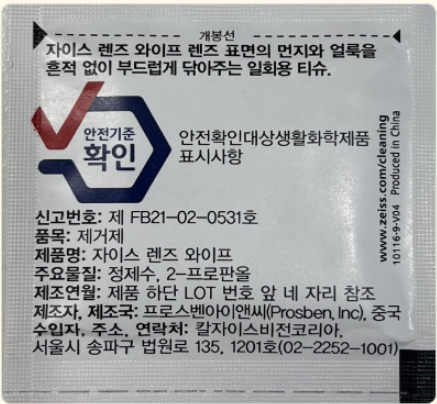

In [ ]:
from PIL import Image

image1 = Image.open("./samples/image1.png")
image1

In [ ]:
%%time

base64_image = encode_image_to_base64("./samples/image1.png")

# https://github.com/sgl-project/sglang/blob/v0.4.4.post3/python/sglang/srt/conversation.py#L499
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": base64_image
                },
            },
            {"type": "text", "text": "Extract all text from the image and separate each line or text segment with a newline character."},
        ],
    }
]

response = predictor.predict({
    'model': 'default',
    'messages': messages,
    'temperature': 0.6,
    'max_new_tokens': 128,
    'do_sample': True,
    'top_p': 0.95,
})

print(response['choices'][0]['message']['content'])

개봉선
자스 렌즈 와이프 렌즈 표면의 먼지와 얼룩을
흔적 없이 부드럽게 닦아주는 일회용 티슈.

안전기준 안전확인대상생활화학제품
확인 표시사항

신고번호: 제 FB21-02-0531호
품목: 제거제
품목: 제거제
제품명: 자스제 렌즈 와이프
주요물질: 정제수, 2-프로판올
제조연월: 제품 하단 LOT 번호 앞 네 자리 참조
제조자, 제조국: 프로스벤아이엔씨(Prosben, Inc.), 중국
수입자, 주소, 연락처: 칼마이즈비진코리아,
서울시 송파구 법원로 135, 1201호(02-2252-1001)
www.2ass.com/cleaning
Produced in China
1017-05-15-04

CPU times: user 1.66 ms, sys: 3.68 ms, total: 5.34 ms
Wall time: 11.5 s


### Invoke endpoint with boto3

Note that you can also invoke the endpoint with boto3. If you have an existing endpoint, you don't need to recreate the predictor and can follow below example to invoke the endpoint with an endpoint name.

In [ ]:
import boto3
import json

sagemaker_runtime = boto3.client('sagemaker-runtime', region_name=region)
endpoint_name = predictor.endpoint_name # you can manually set the endpoint name with an existing endpoint

In [ ]:
%%time

# https://github.com/sgl-project/sglang/blob/v0.4.4.post3/python/sglang/srt/conversation.py#L499
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
                },
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

prompt = {
    'model': 'default',
    'messages': messages,
    'temperature': 0.6,
    'max_new_tokens': 128,
    'do_sample': True,
    'top_p': 0.95
}

response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Body=json.dumps(prompt)
)

response_dict = json.loads(response['Body'].read().decode("utf-8"))
response_content = response_dict['choices'][0]['message']['content']
print(response_content)

The image shows a warm and heartwarming scene of a woman interacting affectionately with a dog on a sandy beach during what appears to be sunset. Here's a detailed description:

1. **Setting**:
   - The scene takes place on a beach, with sand visible in the foreground and the ocean in the background.
   - The sun is low on the horizon, casting a soft, golden glow across the scene, creating a serene and romantic atmosphere.

2. **People and Animals**:
   - A woman is sitting on the sand, facing the dog. She has long, dark hair and is wearing a plaid shirt and rolled-up jeans, suggesting a casual and relaxed outfit.
   - The dog, likely a Labrador Retriever, is light-colored (possibly cream or yellow). It is wearing a harness with a colorful pattern and a leash.
   - The woman and the dog are engaging in a playful or affectionate gesture, with the dog extending its paw toward the woman's hand, as if they are "shaking hands" or giving a high-five.

3. **Mood and Interaction**:
   - The wo

In [ ]:
%%time

base64_image = encode_image_to_base64("./samples/image1.png")

# https://github.com/sgl-project/sglang/blob/v0.4.4.post3/python/sglang/srt/conversation.py#L499
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": base64_image
                },
            },
            {"type": "text", "text": "Extract all text from the image and separate each line or text segment with a newline character."},
        ],
    }
]

prompt = {
    'model': 'default',
    'messages': messages,
    'temperature': 0.6,
    'max_new_tokens': 128,
    'do_sample': True,
    'top_p': 0.95
}

response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Body=json.dumps(prompt)
)

response_dict = json.loads(response['Body'].read().decode("utf-8"))
response_content = response_dict['choices'][0]['message']['content']
print(response_content)

개봉선
자스 렌즈 와이프 렌즈 표면의 먼지와 얼룩을
흔적 없이 부드럽게 닦아주는 일회용 티슈.
안전기준
안전확인대상생활화학제품
표시사항
신고번호: 제 FB21-02-0531호
품목: 제거제
품목: 제거제
제품명: 자스제 렌즈 와이프
주요물질: 정제수, 2-프로판올
제조연월: 제품 하단 LOT 번호 앞 네 자리 참조
제조자, 제조국: 프로스벤아이앤씨(Prosben, Inc), 중국
수입자, 주소, 연락처: 칼마이즈비전코리아,
서울시 송파구 법원로 135, 1201호(02-252-1001)
Produced in China
www.2ass.com/cleaning
101-65-25-04

CPU times: user 4.74 ms, sys: 777 μs, total: 5.51 ms
Wall time: 11.3 s


### Clean up the environment

Make sure to delete the endpoint and other artifacts that were created to avoid unnecessary cost. You can also go to SageMaker AI console to delete all the resources created in this example.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

### References

- [Qwen2.5-VL-32B-Instruct Model Card](https://huggingface.co/Qwen/Qwen2.5-VL-32B-Instruct)
- [SGLang Documentation](https://docs.sglang.ai/index.html) - a fast serving framework for large language models and vision language models
- [sagemaker-genai-hosting-examples/Deepseek/SGLang-Deepseek/deepseek-r1-llama-70b-sglang.ipynb](https://github.com/aws-samples/sagemaker-genai-hosting-examples/blob/main/Deepseek/SGLang-Deepseek/deepseek-r1-llama-70b-sglang.ipynb)